In this notebook I try find an approach for matching two different images (that might differ in angle, scale, etc) of the same route at a climbing hall.  

Future to do:  
* More routes, more phones.
* Parameter Tuning (+ image resize) - especially for performance.
* Must improve matching computation time.
* Compare performance to openCV.
* Test other similar approaches - ORB, SURF..
* Might be a problem when a neighboring route has many features - test.

In [1]:
import numpy as np
import os
import skimage
from skimage.color import rgb2gray
from skimage.feature import SIFT, plot_matches, match_descriptors, ORB
from skimage.transform import rescale
import pandas
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# get all images paths
path_imgs = glob(os.path.join('imgs','*'))
path_imgs[0], len(path_imgs)

('imgs/IMG_4427.JPG', 16)

In [3]:
# import initial example images
imgs = [skimage.io.imread(img) for img in path_imgs]

imgs[0].shape

(3264, 2448, 3)

### Viewing the data

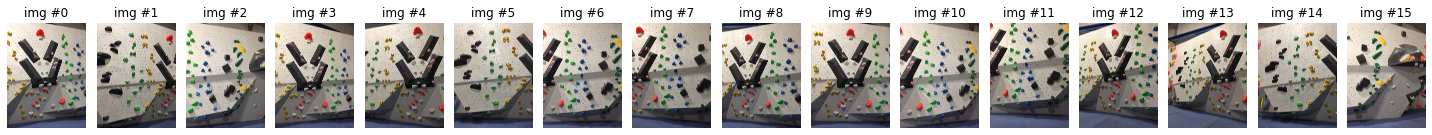

In [4]:
# view images:
fig, ax = plt.subplots(1,16,figsize=(20,8))
for i in range(16):

    #img_num = (i*4)+j
    ax[i].imshow(imgs[i])
    ax[i].set_title(f'img #{(i)}')
    ax[i].axis('off')

plt.tight_layout()

In [5]:
## some manual annotations
## left to right 
route_imgs_dict = {'black_jugs':14, 
                   'light_green_white':5, 
                   'hand_yellow':1, 
                   'white':9, 
                   'orange':9, 
                   'light_green_yellow':10, 
                   'blue':11, 
                   'black_cubes':11}

## SIFT
Scale invariant feature transformation - works on gray scale only.  
On original image size - very slow - ~7s on a high performing workstation per image.  

In [6]:
#SIFT?

In [7]:
max_ratio=0.6
#match_descriptors?

In [8]:
## define SIFT params
descriptor_extractor = SIFT(upsampling=2)

In [9]:
## pre sift rescale (downsample) of image
rescale_size = 0.25

In [10]:
## Function to run the SIFT landmark detection
## First it rescales the image

def sift_features_on_img(img, rescale_size):
    # grayscale
    img = rgb2gray(img)
    # downsample
    img = rescale(img, rescale_size, anti_aliasing=True)

    descriptor_extractor.detect_and_extract(img)
    ### KEYPOINTS IS ONLY FOR VISUALIZATION - but doesnt seem to effect time
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    return keypoints, descriptors

In [11]:
## For visualization only
## Function to get rgb rescaled image

def get_rescaled_rgb(img, rescale_size):
    return np.moveaxis(np.asarray([rescale(img[:,:,i], rescale_size) for i in range(3)]),0,-1)

#### original image
lets start with an example - one image that serves as the original image (i.e. uploaded by route-setter)

In [12]:
# Lets take an example image as the original route image:
org_img_n = 0

In [13]:
%%time

## Performing SIFT feature extraction on org
keypoints1, descriptors1 = sift_features_on_img(imgs[org_img_n], rescale_size)

CPU times: user 1.7 s, sys: 412 ms, total: 2.11 s
Wall time: 2.12 s


#### Destination Image
setting a specific image as the image to compare to original (i.e. image that is taken by a user)

In [14]:
%%time

## Performing SIFT feature extraction + comparison on dest
#### In this example the destination image shares parts of the wall with the org image (with a different angle mostly).

## example destination img - shares wall with org
dest_img_n = 13

## Performing SIFT feature extraction on org
keypoints2, descriptors2 = sift_features_on_img(imgs[dest_img_n], rescale_size)

CPU times: user 1.89 s, sys: 283 ms, total: 2.17 s
Wall time: 2.17 s


In [15]:
%%time
matches_org_dest = match_descriptors(descriptors1, descriptors2, max_ratio=max_ratio, cross_check=True)
f'number of matching points - {len(matches_org_dest)}'

CPU times: user 223 ms, sys: 2.71 ms, total: 225 ms
Wall time: 223 ms


'number of matching points - 30'

(816, 612, 3)


Text(0.5, 1.0, '~same routes from different orientation (w keypoints and matches)')

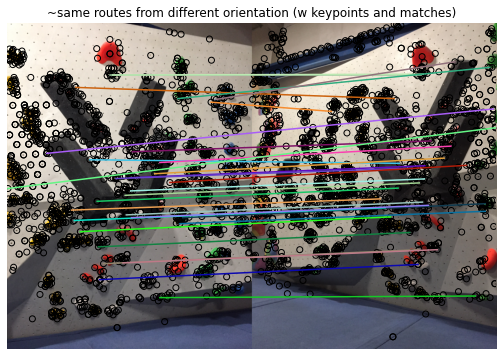

In [16]:
org_rescale_rgb = get_rescaled_rgb(imgs[org_img_n], rescale_size)
print(org_rescale_rgb.shape)
dest_rescale_rgb = get_rescaled_rgb(imgs[dest_img_n], rescale_size)

fig, ax = plt.subplots(figsize=(10, 6))
plot_matches(ax, org_rescale_rgb, dest_rescale_rgb, keypoints1, keypoints2, matches_org_dest)
ax.axis('off')
ax.set_title("~same routes from different orientation (w keypoints and matches)")

In [17]:
%%time

#### In this example the destination image DOES NOT shares parts of the wall with the org image.

dest_img_n = 15

## Performing SIFT feature extraction on org
keypoints2, descriptors2 = sift_features_on_img(imgs[dest_img_n], rescale_size)

matches_org_dest = match_descriptors(descriptors1, descriptors2, max_ratio=max_ratio, cross_check=True)

f'number of matching points - {len(matches_org_dest)}'

CPU times: user 1.66 s, sys: 351 ms, total: 2.01 s
Wall time: 2.02 s


'number of matching points - 3'

(816, 612, 3)


Text(0.5, 1.0, 'Different routes AKA control (w keypoints and matches)')

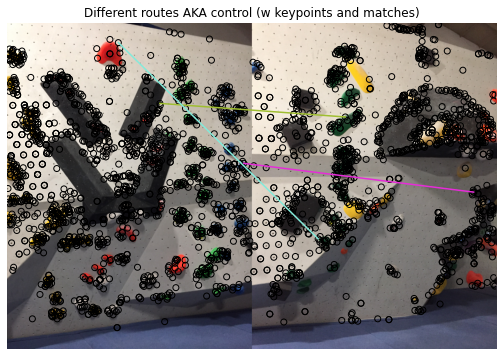

In [18]:
org_rescale_rgb = get_rescaled_rgb(imgs[org_img_n], rescale_size)
print(org_rescale_rgb.shape)
dest_rescale_rgb = get_rescaled_rgb(imgs[dest_img_n], rescale_size)

fig, ax = plt.subplots(figsize=(10, 6))
plot_matches(ax, org_rescale_rgb, dest_rescale_rgb, keypoints1, keypoints2, matches_org_dest)
ax.axis('off')
ax.set_title("Different routes AKA control (w keypoints and matches)")

### Loop over all images
still from my phone

In [19]:
%%time
## Get descriptors for all images

print(f'number of images {len(imgs)}')

keypoints_and_descriptors_all_imgs = [sift_features_on_img(img, rescale_size) for img in imgs]

number of images 16
CPU times: user 27.7 s, sys: 5.61 s, total: 33.4 s
Wall time: 33.5 s


In [20]:
%%time
## match all images with all images
matches_all_images = [[match_descriptors(KnD1[1], KnD2[1], max_ratio=max_ratio, cross_check=True) 
                       for KnD2 in keypoints_and_descriptors_all_imgs] for KnD1 in keypoints_and_descriptors_all_imgs]
len(matches_all_images), len(matches_all_images[0])

CPU times: user 51.7 s, sys: 80.8 ms, total: 51.8 s
Wall time: 51.8 s


(16, 16)

In [21]:
### UH OH - thats a very long time for comparing the database across 256 images!!!

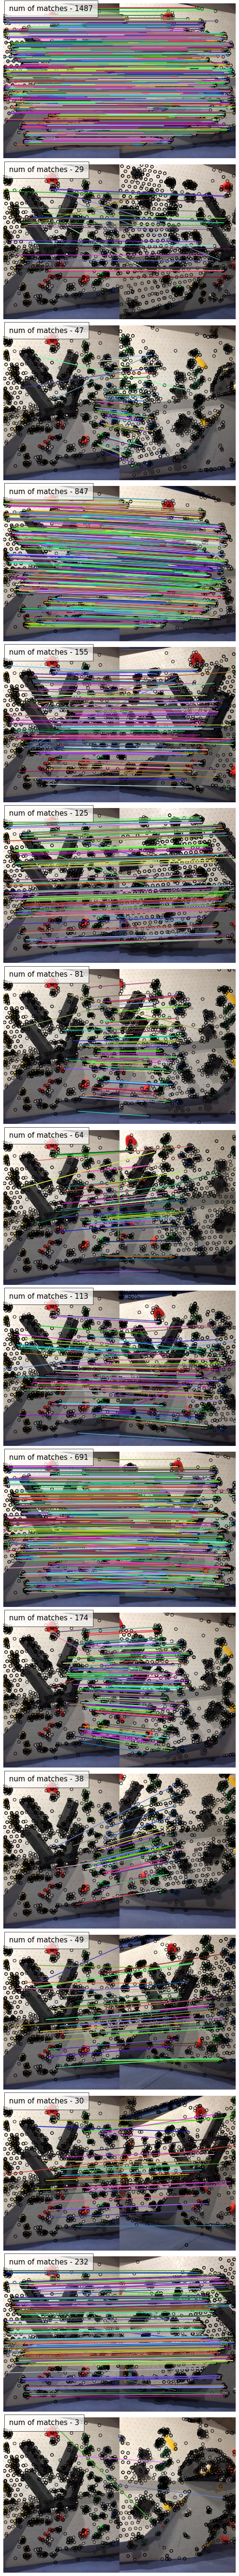

In [22]:
## all matching figures for one figure:

img_n = 0

org_rescale_rgb = get_rescaled_rgb(imgs[img_n], rescale_size)

fig, ax = plt.subplots(16, figsize=(8, 75))
for i in range(len(imgs)):

    dest_rescale_rgb = get_rescaled_rgb(imgs[i], rescale_size)

    plot_matches(ax[i], org_rescale_rgb, dest_rescale_rgb, keypoints_and_descriptors_all_imgs[img_n][0], 
                 keypoints_and_descriptors_all_imgs[i][0], matches_all_images[img_n][i])
    ax[i].axis('off')
    ax[i].text(30, 40, f'num of matches - {len(matches_all_images[img_n][i])}', 
               bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10}, fontsize=15)
    
plt.tight_layout()

In [23]:
# ## all matching figures for one figure:

# img_n = 1

# org_rescale_rgb = get_rescaled_rgb(imgs[img_n], rescale_size)

# fig, ax = plt.subplots(16,1, figsize=(8, 75))
# for i in range(len(imgs)):

#     dest_rescale_rgb = get_rescaled_rgb(imgs[i], rescale_size)

#     plot_matches(ax[i], org_rescale_rgb, dest_rescale_rgb, keypoints_and_descriptors_all_imgs[img_n][0], keypoints_and_descriptors_all_imgs[i][0], matches_all_images[img_n][i])
#     ax[i].axis('off')
#     ax[i].text(30, 40, f'num of matches - {len(matches_all_images[img_n][i])}', 
#                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10}, fontsize=15)
    
# plt.tight_layout()